## DQN 특징

1. 더 깊은 네트워크 사용
2. experience replay 사용
3. separate network 사용

아래 코드는 1, 2번만 적용하고 3번은 적용하지 않아서 학습에 안정성이 떨어짐

In [1]:
import gymnasium
import numpy as np
import random
import torch
import copy
import collections
from tqdm import tqdm

In [2]:
env = gymnasium.make('CartPole-v1')
hidden_size = 10
q = torch.nn.Sequential(
    torch.nn.Linear(*env.observation_space.shape, hidden_size, bias=False),
    torch.nn.Tanh(),
    torch.nn.Linear(hidden_size, env.action_space.n, bias=False)
)

In [3]:
lr = 0.1
discount = 0.9
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(q.parameters(), lr=lr)

In [4]:
def train(optimizer, batch):
    optimizer.zero_grad()
    losses = []
    for u, action, r, v, terminated in batch:
        uq = q(u) 
        if terminated:
            uq[action] = r
        else:
            uq[action] = r + discount * torch.max(q(v))
        loss = criterion(uq, q(u))
        losses.append(loss)
    sum(losses).backward()
    optimizer.step()

In [5]:
num_episodes = 5000
batch_size = 10
sync_interval = 10
replay_size = 10000
replay_buffer = collections.deque()
rewards = []
for i in tqdm(range(num_episodes)):
    u, info = env.reset()
    u = torch.tensor(u)
    reward = 0
    while True:
        uq = q(u)
        e = 1 / (i / 50 + 10)
        if np.random.random() < e:
            action = env.action_space.sample()
        else:
            action = torch.argmax(uq).cpu().detach().item()
        v, r, terminated, truncated, info = env.step(action)
        v = torch.tensor(v)
        if terminated:
            r = -100
        reward += r
        replay_buffer.append([u, action, r, v, terminated])
        if len(replay_buffer) > replay_size:
            replay_buffer.popleft()
        u = v
        if terminated or truncated:
            break
    
    if len(replay_buffer) >= batch_size:
        for _ in range(50):
            batch = random.sample(replay_buffer, k=batch_size)
            train(optimizer, batch)

    rewards.append(reward)
    if (i + 1) % 100 == 0:
        print(reward)

  0%|          | 0/5000 [00:00<?, ?it/s]

  2%|▏         | 100/5000 [00:37<29:13,  2.80it/s]

-91.0


  4%|▍         | 200/5000 [01:11<26:19,  3.04it/s]

-62.0


  6%|▌         | 300/5000 [01:51<31:25,  2.49it/s]

-75.0


  8%|▊         | 400/5000 [02:34<33:27,  2.29it/s]

107.0


 10%|█         | 500/5000 [03:17<30:37,  2.45it/s]

-91.0


 12%|█▏        | 600/5000 [03:59<31:33,  2.32it/s]

-33.0


 14%|█▍        | 700/5000 [04:42<28:07,  2.55it/s]

-37.0


 16%|█▌        | 800/5000 [05:24<27:04,  2.59it/s]

-77.0


 18%|█▊        | 900/5000 [06:05<27:37,  2.47it/s]

-75.0


 20%|██        | 1000/5000 [06:44<26:32,  2.51it/s]

-91.0


 22%|██▏       | 1100/5000 [07:26<25:08,  2.59it/s]

-91.0


 24%|██▍       | 1200/5000 [08:06<25:15,  2.51it/s]

-93.0


 26%|██▌       | 1300/5000 [08:46<25:38,  2.41it/s]

-87.0


 28%|██▊       | 1400/5000 [09:27<22:46,  2.63it/s]

-72.0


 30%|███       | 1500/5000 [10:11<26:57,  2.16it/s]

-93.0


 32%|███▏      | 1600/5000 [10:58<27:57,  2.03it/s]

500.0


 34%|███▍      | 1700/5000 [11:42<23:17,  2.36it/s]

-75.0


 36%|███▌      | 1800/5000 [12:28<23:50,  2.24it/s]

-88.0


 38%|███▊      | 1900/5000 [13:13<21:54,  2.36it/s]

-76.0


 40%|████      | 2000/5000 [13:59<20:40,  2.42it/s]

-72.0


 42%|████▏     | 2100/5000 [14:41<15:47,  3.06it/s]

-51.0


 44%|████▍     | 2200/5000 [15:19<17:58,  2.60it/s]

-92.0


 46%|████▌     | 2300/5000 [15:56<15:58,  2.82it/s]

-28.0


 48%|████▊     | 2400/5000 [16:31<15:27,  2.80it/s]

-92.0


 50%|█████     | 2500/5000 [17:08<14:58,  2.78it/s]

-53.0


 52%|█████▏    | 2600/5000 [17:44<14:47,  2.71it/s]

-68.0


 54%|█████▍    | 2700/5000 [18:21<13:48,  2.78it/s]

-56.0


 56%|█████▌    | 2800/5000 [18:59<14:58,  2.45it/s]

-42.0


 58%|█████▊    | 2900/5000 [19:40<13:46,  2.54it/s]

-20.0


 60%|██████    | 3000/5000 [20:21<12:31,  2.66it/s]

-90.0


 62%|██████▏   | 3100/5000 [21:01<16:07,  1.96it/s]

-61.0


 64%|██████▍   | 3200/5000 [21:40<11:51,  2.53it/s]

-83.0


 66%|██████▌   | 3300/5000 [22:19<10:36,  2.67it/s]

-91.0


 68%|██████▊   | 3400/5000 [22:57<11:15,  2.37it/s]

-92.0


 70%|███████   | 3500/5000 [23:36<09:29,  2.63it/s]

-70.0


 72%|███████▏  | 3600/5000 [24:16<10:07,  2.30it/s]

-92.0


 74%|███████▍  | 3700/5000 [24:53<07:49,  2.77it/s]

-90.0


 76%|███████▌  | 3800/5000 [25:32<09:20,  2.14it/s]

-92.0


 78%|███████▊  | 3900/5000 [26:13<07:16,  2.52it/s]

-66.0


 80%|████████  | 4000/5000 [26:52<07:39,  2.17it/s]

-91.0


 82%|████████▏ | 4100/5000 [27:30<05:41,  2.64it/s]

-87.0


 84%|████████▍ | 4200/5000 [28:12<05:29,  2.43it/s]

-85.0


 86%|████████▌ | 4300/5000 [28:52<04:31,  2.58it/s]

-88.0


 88%|████████▊ | 4400/5000 [29:32<04:05,  2.44it/s]

-92.0


 90%|█████████ | 4500/5000 [30:17<04:01,  2.07it/s]

-79.0


 92%|█████████▏| 4600/5000 [30:54<02:11,  3.03it/s]

-91.0


 94%|█████████▍| 4700/5000 [31:29<01:42,  2.93it/s]

17.0


 96%|█████████▌| 4800/5000 [32:02<01:06,  3.00it/s]

-84.0


 98%|█████████▊| 4900/5000 [32:38<00:34,  2.94it/s]

-78.0


100%|██████████| 5000/5000 [33:12<00:00,  2.51it/s]

-93.0


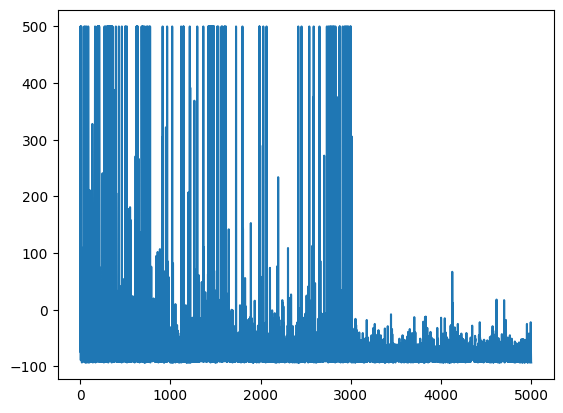

In [6]:
import matplotlib.pyplot as plt
plt.plot(rewards)

In [7]:
env = gymnasium.make('CartPole-v1', render_mode='human')
rewards = []
for i in range(10):
    reward = 0
    u, info = env.reset()
    u = torch.tensor(u)
    while True:
        action = torch.argmax(q(u)).cpu().detach().item()
        v, r, terminated, truncated, info = env.step(action)
        v = torch.tensor(v)
        reward += r
        u = v
        if terminated or truncated:
            break
    rewards.append(reward)
env.close()
rewards

[9.0, 10.0, 10.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 8.0]

In [8]:
env.close()